# Here, we analyze how highly variable genes in a colon data set change after different downsampling thresholds.

Evaluation of different read count thresholds

1. Upload colon data
2. View highly expressed genes
3. Apply various threshold functions (500, 1000, 1500, etc)
4. View highly expressed genes

Bonus: look at which genes get cut out by down sample function 

In [1]:
import pandas as pd
import anndata as ad
import scanpy as sc
import glob
import numpy as np
import QCPipe
import skmisc
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Upload colon data

In [2]:
path = 'data/GSE185224_clustered_annotated_adata_k10_lr0.92_v1.7.h5ad'
adata = ad.read(path)

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# 2. View highly variable genes

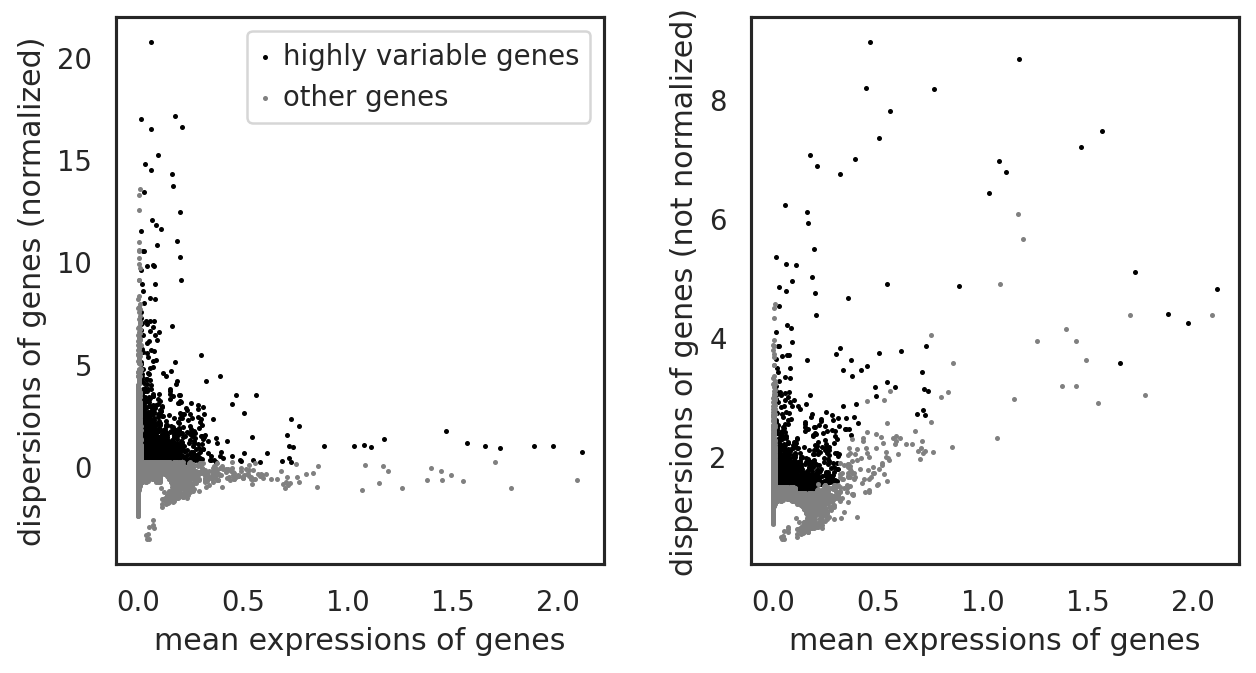

In [3]:
sc.pl.highly_variable_genes(adata)

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=10, flavor='cell_ranger')

In [5]:
hv_idx = adata.var['highly_variable']

In [6]:
highly_variable =  adata.var[hv_idx == True]
highly_variable

highly_variable         means   dispersions  dispersions_norm  \
AC245041.1             True  1.272222e-06  7.738360e+05         53.596142   
CACNA1G                True  1.854706e-06  5.119895e+05         35.312977   
FAM135B                True  1.452954e-06  7.254544e+05         50.217949   
FFAR3                  True  1.365382e-06  7.431889e+05         51.456242   
GPN1                   True  6.332670e-07  1.584102e+06        110.172119   
KCNA7                  True  1.014690e-07  9.665784e+06        674.467407   
LINC02573              True  1.788862e-06  5.896280e+05         40.734005   
OR7C1                  True  1.639767e-06  6.432241e+05         44.476299   
PIGH                   True  2.630960e-08  3.759612e+07       2624.674561   
PITPNB                 True  1.071229e-06  9.224356e+05         63.971958   

                    mean       std  s_phase  g2m_phase         gene_ids  \
AC245041.1  1.873423e-10  0.477238    False      False  ENSG00000273760   
CACNA1G    -5.856830e-11  0.275433    False      False  ENSG00000006283   
FAM135B     4.607004e-11  0.338217    False      False  ENSG00000147724   
FFAR3       3.424335e-10  0.451564    False      False  ENSG00000185897   
GPN1        2.439613e-10  0.998861    False      False  ENSG00000198522   
KCNA7       3.629267e-10  0.464200    False      False  ENSG00000104848   
LINC02573  -2.451407e-11  0.313869    False      False  ENSG00000233236   
OR7C1       1.880212e-11  0.289208    False      False  ENSG00000127530   
PIGH       -5.032129e-10  0.999579    False      False  ENSG00000100564   
PITPNB     -3.182356e-10  0.997199    False      False  ENSG00000180957   

              feature_types  ... Donor_3-n_cells_by_counts  \
AC245041.1  Gene Expression  ...                      25.0   
CACNA1G     Gene Expression  ...                       8.0   
FAM135B     Gene Expression  ...                       9.0   
FFAR3       Gene Expression  ...                       NaN   
GPN1        Gene Expression  ...                     636.0   
KCNA7       Gene Expression  ...                       8.0   
LINC02573   Gene Expression  ...                      14.0   
OR7C1       Gene Expression  ...                       9.0   
PIGH        Gene Expression  ...                     653.0   
PITPNB      Gene Expression  ...                    1306.0   

           Donor_2-mean_counts  Donor_1-mean_counts  Donor_3-mean_counts  \
AC245041.1            0.001115             0.000933             0.005018   
CACNA1G                    NaN             0.000622             0.001807   
FAM135B               0.000496             0.000778             0.001807   
FFAR3                 0.003841             0.001555                  NaN   
GPN1                  0.099120             0.129705             0.145925   
KCNA7                 0.000867             0.003110             0.001807   
LINC02573                  NaN                  NaN             0.004416   
OR7C1                      NaN             0.000622             0.001807   
PIGH                  0.086978             0.135303             0.149739   
PITPNB                0.219799             0.286159             0.355279   

            Donor_2-pct_dropout_by_counts  Donor_1-pct_dropout_by_counts  \
AC245041.1                      99.900880                      99.906687   
CACNA1G                               NaN                      99.937792   
FAM135B                         99.950440                      99.922240   
FFAR3                           99.640689                      99.860031   
GPN1                            91.091562                      89.175739   
KCNA7                           99.913270                      99.720062   
LINC02573                             NaN                            NaN   
OR7C1                                 NaN                      99.937792   
PIGH                            91.859745                      88.040435   
PITPNB                          81.848594                 

In [7]:
highly_variable = highly_variable.sort_values('dispersions', ascending=False)

Text(0.5, 1.0, 'Highly variable genes')

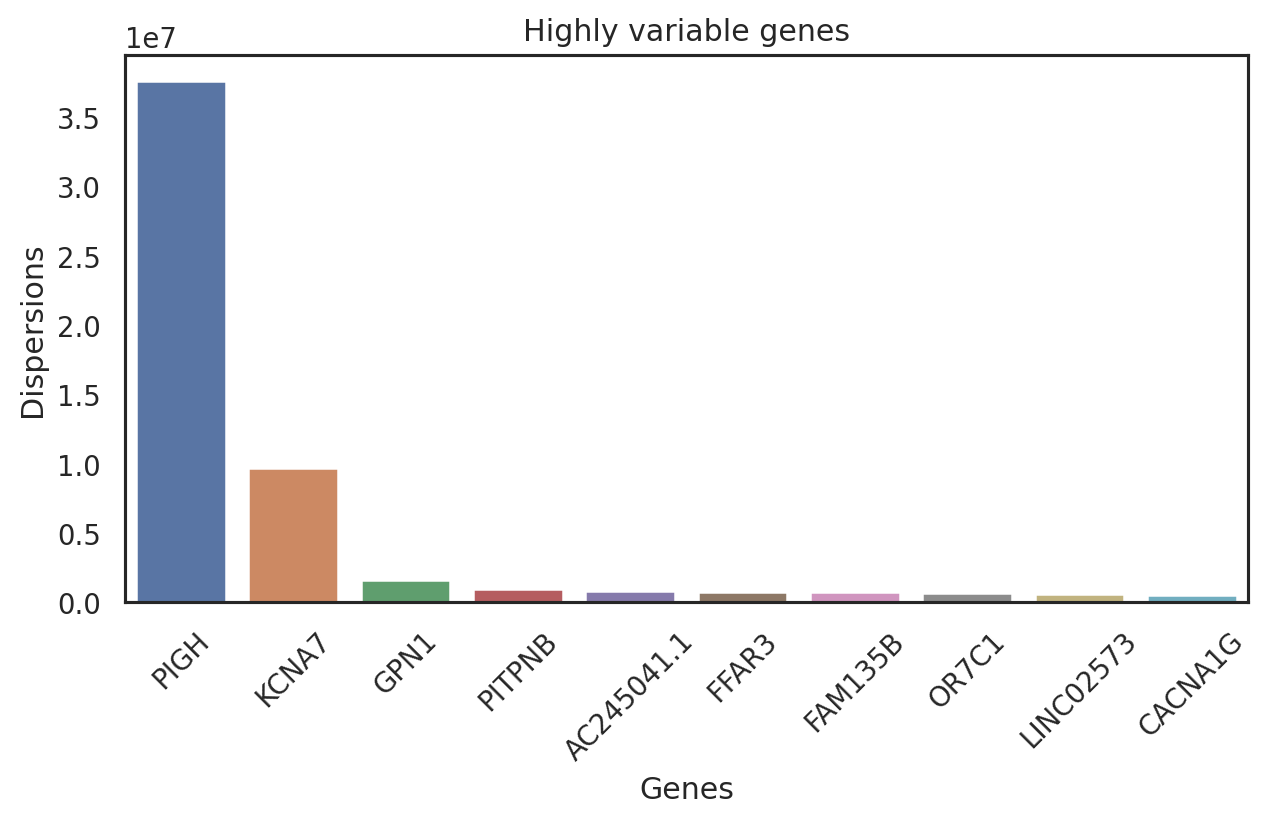

In [8]:
plt.figure(figsize=(8,4))
plt.xticks(rotation=45)
sns.barplot(data=highly_variable, x=highly_variable.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes')

# 3. Apply down sample function

In [9]:
# standardize library sizes by removing nucs with low libs and downsampling the rest
def standardize_libs( adata_obj, tar_lib_sz=1000, seed=123):
    # make sure counts for each nuc are current
    sc.pp.calculate_qc_metrics( adata_obj, percent_top=None, inplace=True)
    # print number of nucs to be removed
    print( "Number of low lib nucs removed per run:")
    low_mk = ( adata_obj.obs['total_counts']<=tar_lib_sz)
    print( adata_obj.obs.loc[low_mk,'batch'].value_counts())# / adata.obs['label'].value_counts())
    
    # remove nucs with low library sizes
    #### comment out line below to keep low UMI count nuclei ####
    sc.pp.filter_cells( adata_obj, min_counts=tar_lib_sz, copy=False)
    
    # downsample nuc total counts over target library size
    sc.pp.downsample_counts( adata_obj, counts_per_cell=tar_lib_sz, copy=False, replace=False, random_state=seed)
    # due to scanpy bug in this version have to reset dtype
    adata_obj.X = adata_obj.X.astype( float)
    return

In [10]:
adata = ad.read(path)

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
adata.X = adata.layers['raw']

In [12]:
adata.X.toarray()

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
adata_500 = adata.copy()
adata_1000 = adata.copy()
adata_1500 = adata.copy()
adata_2000 = adata.copy()

In [14]:
adata_500.X.toarray()

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
standardize_libs(adata_obj=adata_500, tar_lib_sz=500, seed=123)
standardize_libs(adata_obj=adata_1000, tar_lib_sz=1000, seed=123)
standardize_libs(adata_obj=adata_1500, tar_lib_sz=1500, seed=123)
standardize_libs(adata_obj=adata_2000, tar_lib_sz=2000, seed=123)

Number of low lib nucs removed per run:
2    0
1    0
0    0
Name: batch, dtype: int64


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of low lib nucs removed per run:
2    0
1    0
0    0
Name: batch, dtype: int64


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of low lib nucs removed per run:
0    10
2     0
1     0
Name: batch, dtype: int64


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of low lib nucs removed per run:
0    84
2     0
1     0
Name: batch, dtype: int64


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


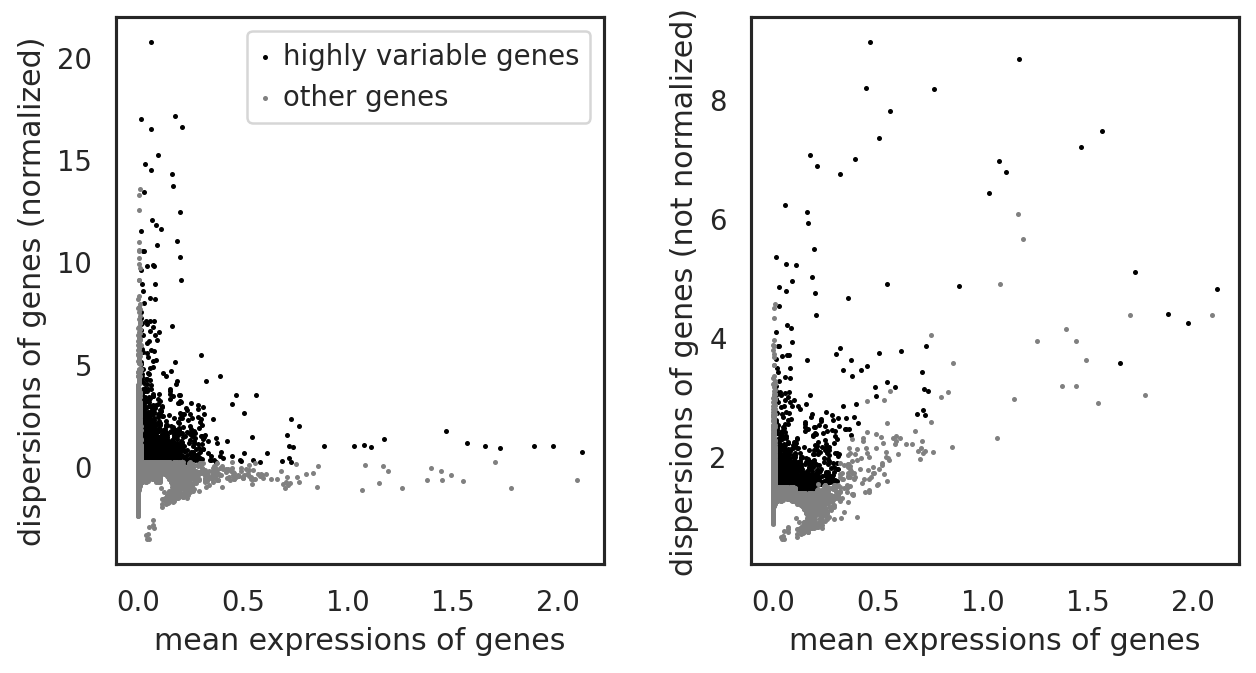

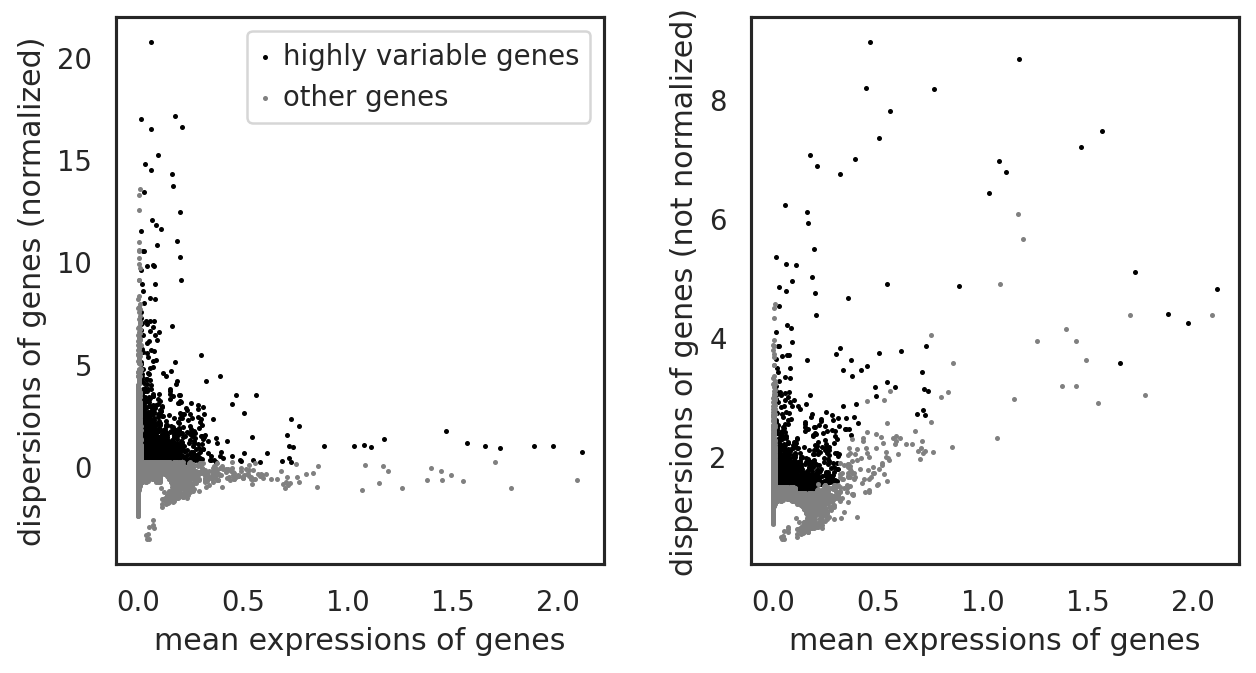

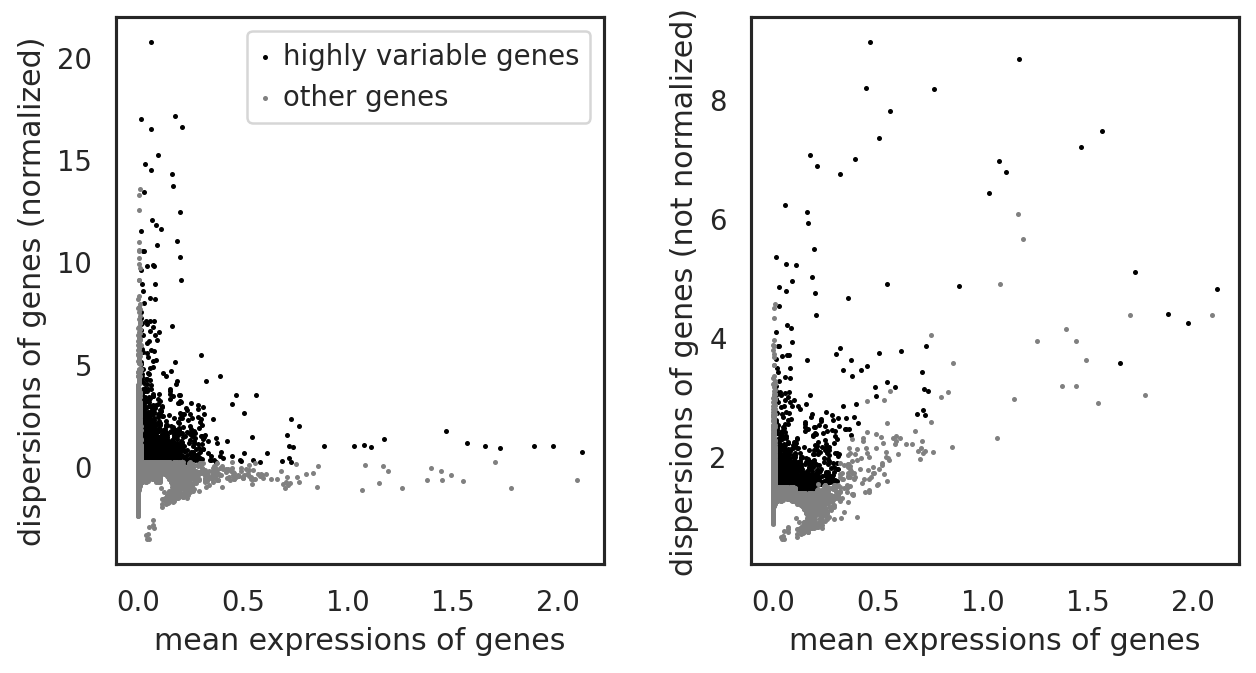

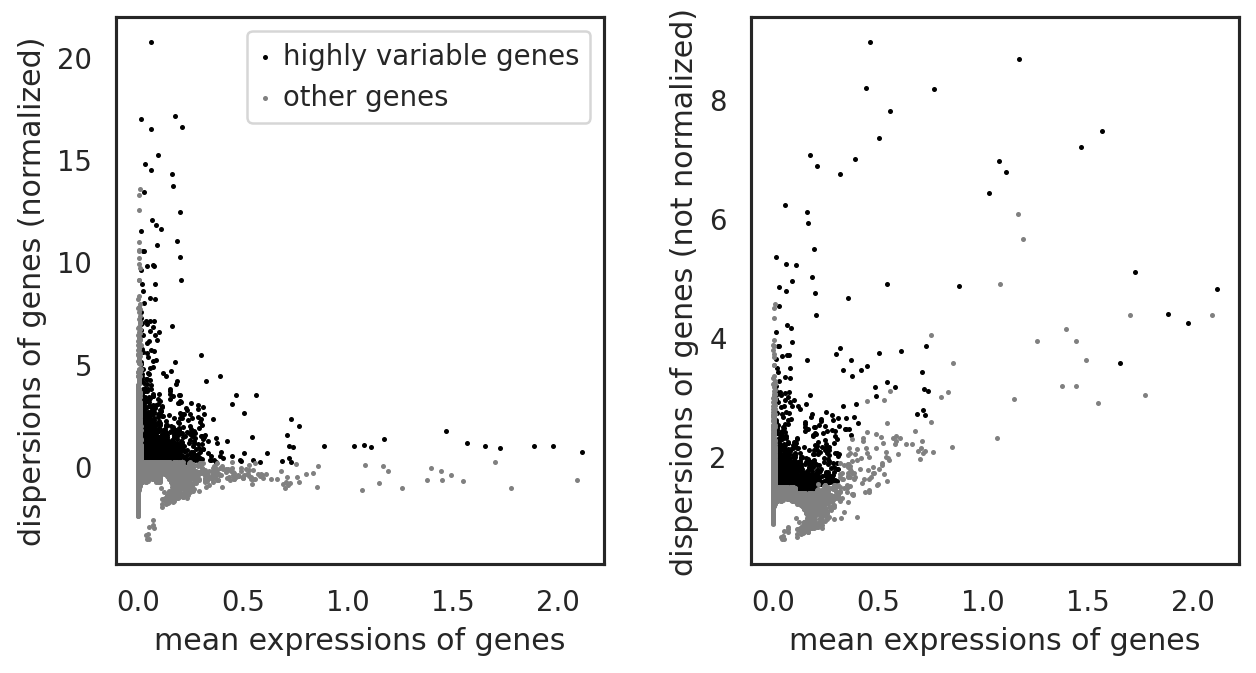

In [16]:
sc.pl.highly_variable_genes(adata_500)
sc.pl.highly_variable_genes(adata_1000)
sc.pl.highly_variable_genes(adata_1500)
sc.pl.highly_variable_genes(adata_2000)

# Why does this look so wrong 

# 4. View highly variable genes

In [17]:
sc.pp.normalize_total(adata_500)
sc.pp.normalize_total(adata_1000)
sc.pp.normalize_total(adata_1500)
sc.pp.normalize_total(adata_2000)

In [18]:
sc.pp.log1p(adata_500)
sc.pp.log1p(adata_1000)
sc.pp.log1p(adata_1500)
sc.pp.log1p(adata_2000)

In [19]:
sc.pp.highly_variable_genes(adata_500, n_top_genes=10, flavor='seurat')
sc.pp.highly_variable_genes(adata_1000, n_top_genes=10, flavor='seurat')
sc.pp.highly_variable_genes(adata_1500, n_top_genes=10, flavor='seurat')
sc.pp.highly_variable_genes(adata_2000, n_top_genes=10, flavor='seurat')

In [20]:
hv_idx_500 = adata_500.var['highly_variable']
hv_idx_1000 = adata_1000.var['highly_variable']
hv_idx_1500 = adata_1500.var['highly_variable']
hv_idx_2000 = adata_2000.var['highly_variable']

In [21]:
hv_500 =  adata_500.var[hv_idx_500 == True]
hv_1000 =  adata_1000.var[hv_idx_1000 == True]
hv_1500 =  adata_1500.var[hv_idx_1500 == True]
hv_2000 =  adata_2000.var[hv_idx_2000 == True]

In [22]:
hv_500 = hv_500.sort_values('dispersions', ascending=False)
hv_1000 = hv_1000.sort_values('dispersions', ascending=False)
hv_1500 = hv_1500.sort_values('dispersions', ascending=False)
hv_2000 = hv_2000.sort_values('dispersions', ascending=False)

Text(0.5, 1.0, 'Highly variable genes: 500 cut off')

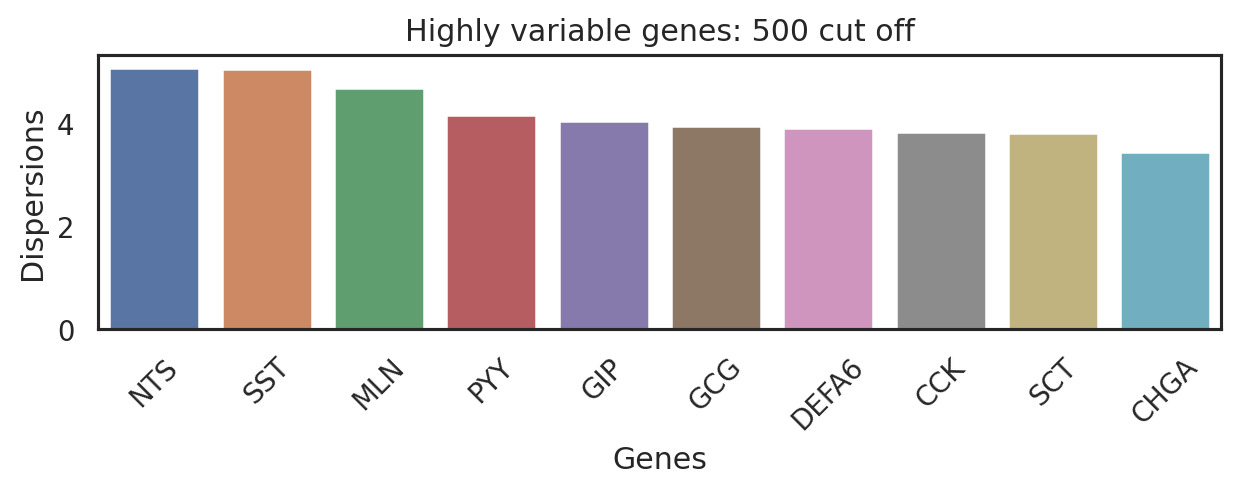

In [23]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_500, x=hv_500.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 500 cut off')

Text(0.5, 1.0, 'Highly variable genes: 1000 cut off')

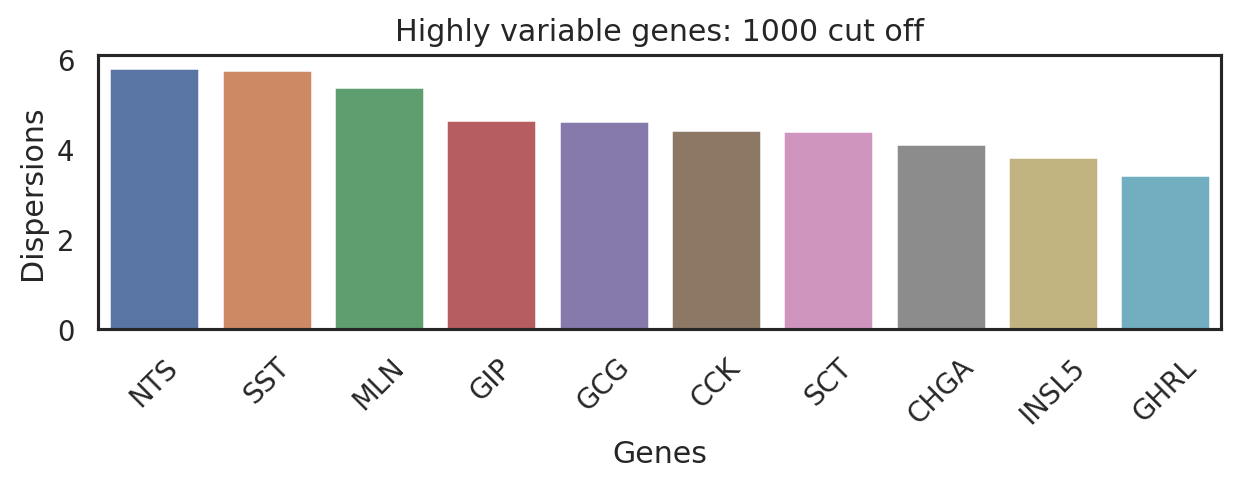

In [24]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_1000, x=hv_1000.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 1000 cut off')

Text(0.5, 1.0, 'Highly variable genes: 1500 cut off')

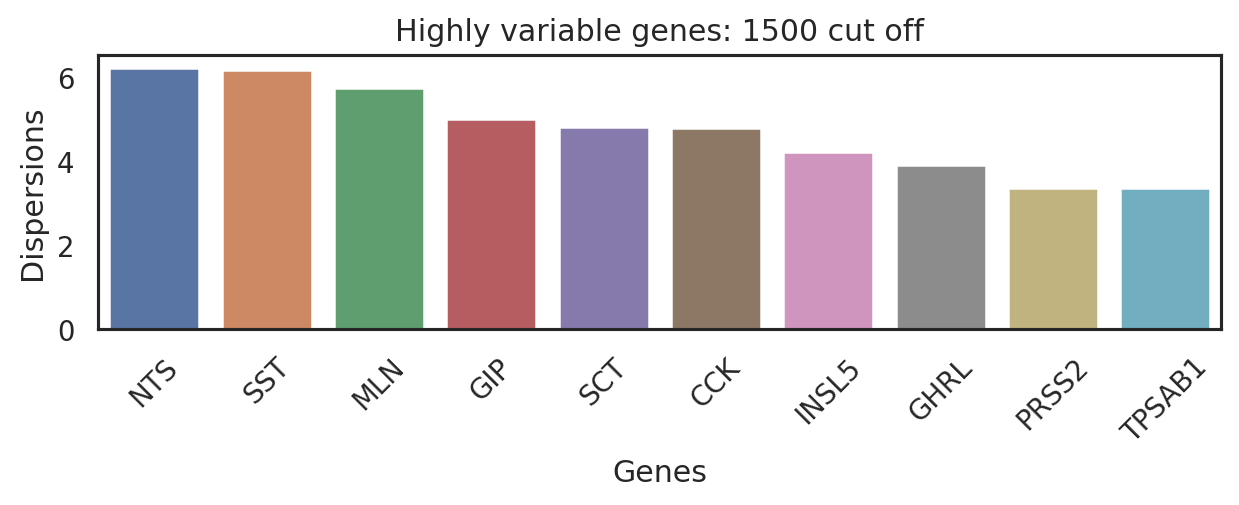

In [25]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_1500, x=hv_1500.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 1500 cut off')

Text(0.5, 1.0, 'Highly variable genes: 2000 cut off')

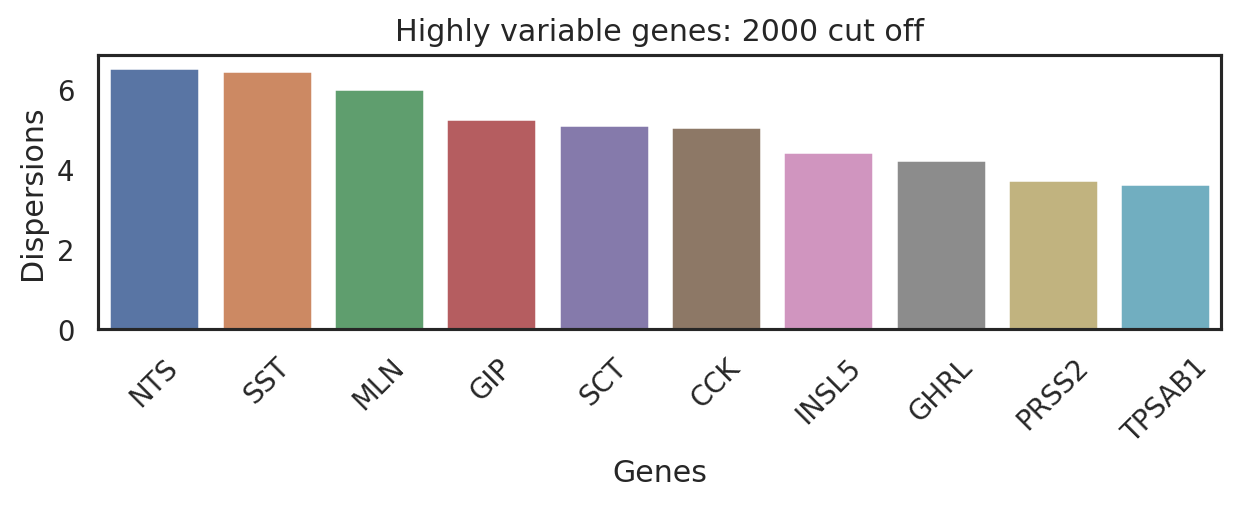

In [26]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_2000, x=hv_2000.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 2000 cut off')

# So, what changed?

500 -> 1000

* Lost: PYY, DEFA6
* Gained: INSL5, GHRL

1000 -> 1500

* Lost: GCG, CHGA
* Gained: PRSS2, TPSAB1

1500 -> 2000

* Lost: None
* Gained: None


## Notes on top 10 genes @ 2000 cut off (from NCBI)
- NTS: neurotensin, CNS neurotransmitter, maintenance of gut structure and function
- SST: somatostatin, "This hormone is an important regulator of the endocrine system through its interactions with pituitary growth hormone, thyroid stimulating hormone, and most hormones of the gastrointestinal tract."
- MLN: motilin, "secreted by cells of the small intestine to regulate gastrointestinal contractions and motility"
- GIP: gastric inihibitory polypeptide, "maintaining glucose homeostasis as it is a potent stimulator of insulin secretion from pancreatic beta-cells following food ingestion and nutrient absorption" 
- SCT: secretin, "secreted by endocrine S cells in the proximal small intestinal mucosa as a prohormone"
- CCK: cholecystokinin, "regulate gastric acid secretion and food intake"
- INSL5: insulin like 5, 
- GHRL: ghrelin and obestatin prepropeptide, "Ghrelin is a powerful appetite stimulant", 
- PRSS2: serine protease 2
- TPSAB: tryptase alpha/beta 1

In [27]:
# let's umap

In [28]:
sc.tl.umap(adata)

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


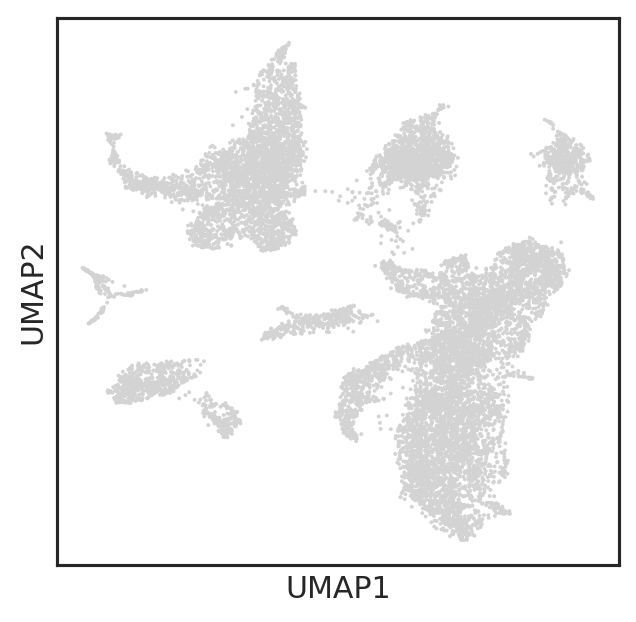

In [29]:
sc.pl.umap(adata)

In [30]:
sc.tl.umap(adata_500)
sc.tl.umap(adata_1000)
sc.tl.umap(adata_1500)
sc.tl.umap(adata_2000)

In [31]:
hv_2000.index

Index(['NTS', 'SST', 'MLN', 'GIP', 'SCT', 'CCK', 'INSL5', 'GHRL', 'PRSS2',
       'TPSAB1'],
      dtype='object')

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


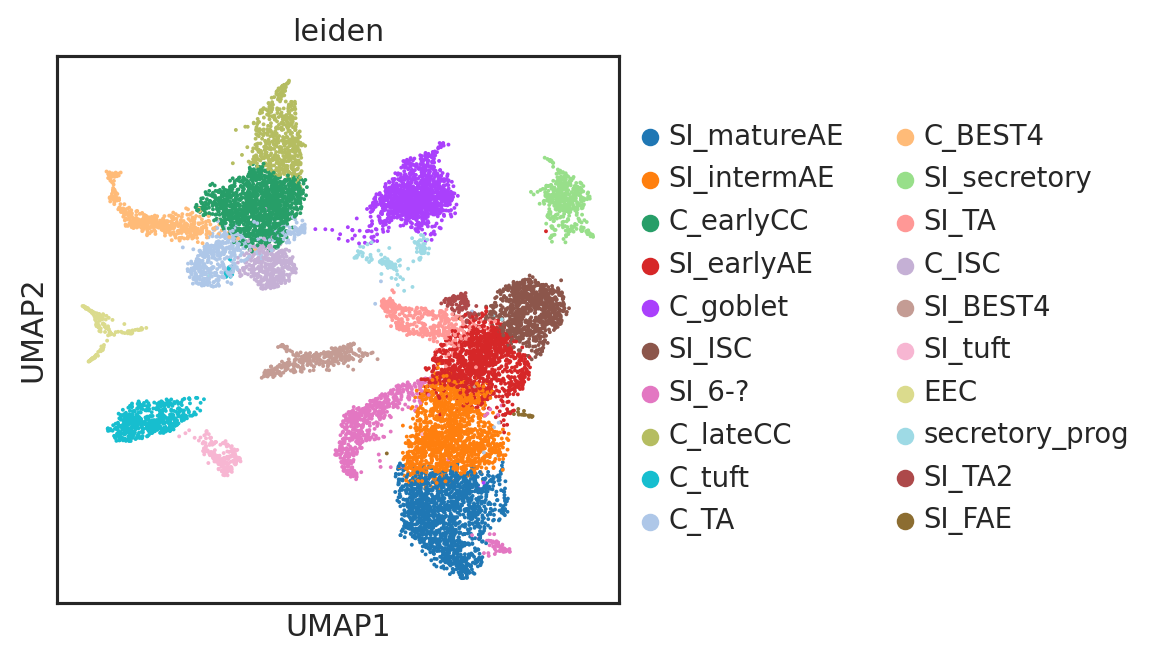

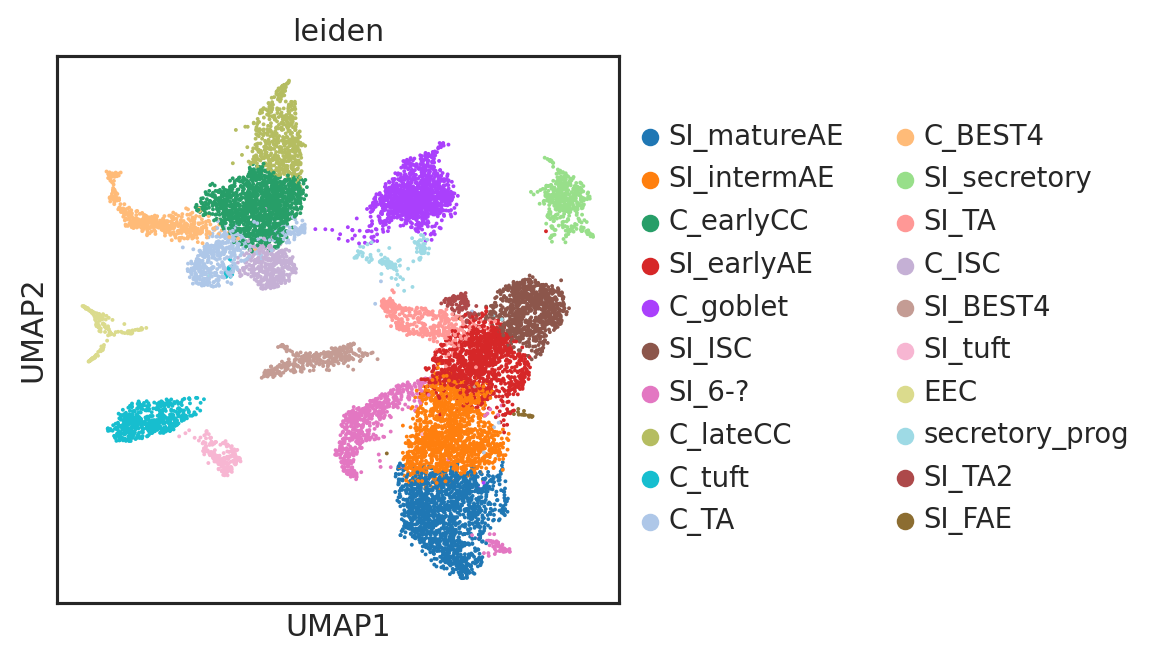

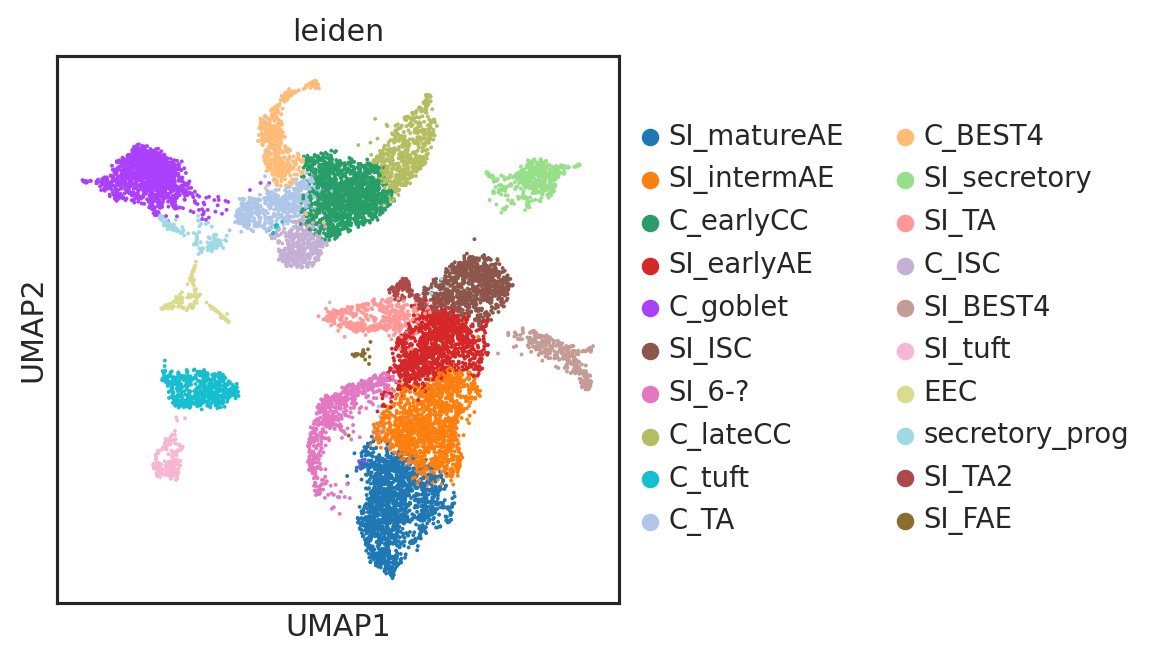

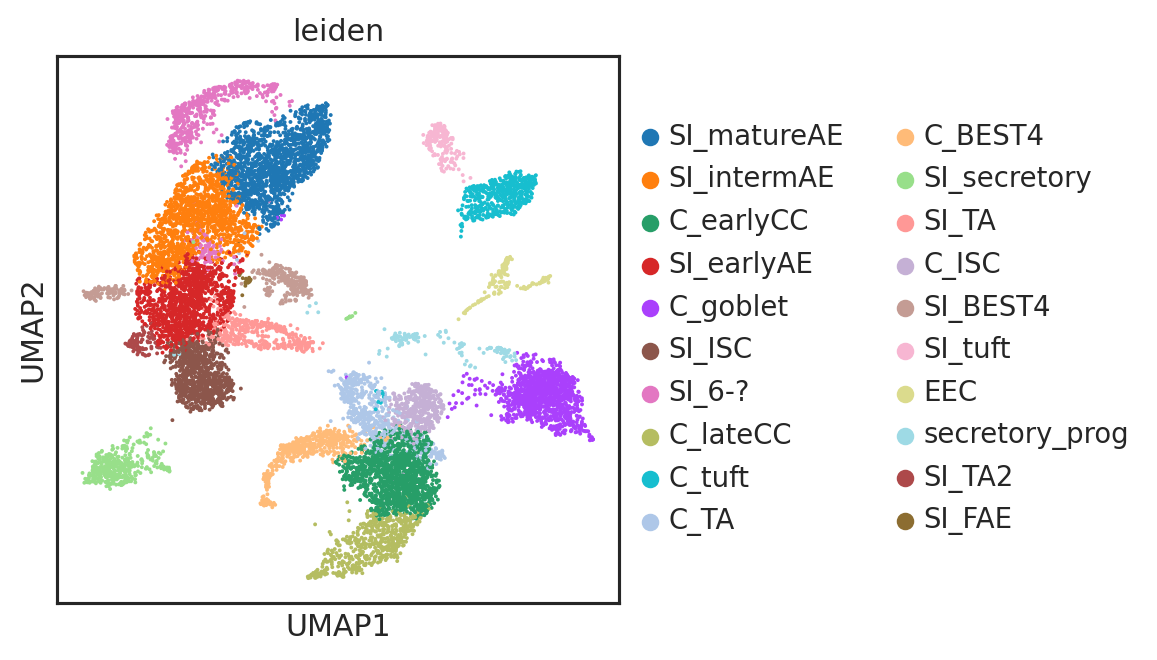

In [32]:
sc.pl.umap(adata_500, color='leiden')
sc.pl.umap(adata_1000, color='leiden')
sc.pl.umap(adata_1500, color='leiden')
sc.pl.umap(adata_2000, color='leiden')

# The short answer, is it seems like there isn't a ton of information gained/ lost above the 1000 count threshold. But we can find more evidence and dig a little deeper on that.

# Let's try two more things:
1. Try even lower threshold than 500 (because the difference between 0 -> 500 is the most significant)
2. Zoom out to the top 100 highly variable genes

In [33]:
adata_100 = adata.copy()
adata_200 = adata.copy()
adata_300 = adata.copy()
adata_400 = adata.copy()

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [34]:
standardize_libs(adata_obj=adata_100, tar_lib_sz=100, seed=123)
standardize_libs(adata_obj=adata_200, tar_lib_sz=200, seed=123)
standardize_libs(adata_obj=adata_300, tar_lib_sz=300, seed=123)
standardize_libs(adata_obj=adata_400, tar_lib_sz=400, seed=123)

Number of low lib nucs removed per run:
2    0
1    0
0    0
Name: batch, dtype: int64


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of low lib nucs removed per run:
2    0
1    0
0    0
Name: batch, dtype: int64


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of low lib nucs removed per run:
2    0
1    0
0    0
Name: batch, dtype: int64


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of low lib nucs removed per run:
2    0
1    0
0    0
Name: batch, dtype: int64


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [35]:
sc.pp.normalize_total(adata_100)
sc.pp.normalize_total(adata_200)
sc.pp.normalize_total(adata_300)
sc.pp.normalize_total(adata_400)

sc.pp.log1p(adata_100)
sc.pp.log1p(adata_200)
sc.pp.log1p(adata_300)
sc.pp.log1p(adata_400)

sc.pp.highly_variable_genes(adata_100, n_top_genes=20, flavor='seurat')
sc.pp.highly_variable_genes(adata_200, n_top_genes=20, flavor='seurat')
sc.pp.highly_variable_genes(adata_300, n_top_genes=20, flavor='seurat')
sc.pp.highly_variable_genes(adata_400, n_top_genes=20, flavor='seurat')

hv_idx_100 = adata_100.var['highly_variable']
hv_idx_200 = adata_200.var['highly_variable']
hv_idx_300 = adata_300.var['highly_variable']
hv_idx_400 = adata_400.var['highly_variable']

hv_100 =  adata_100.var[hv_idx_100 == True]
hv_200 =  adata_200.var[hv_idx_200 == True]
hv_300 =  adata_300.var[hv_idx_300 == True]
hv_400 =  adata_400.var[hv_idx_400 == True]

hv_100 = hv_100.sort_values('dispersions', ascending=False)
hv_200 = hv_200.sort_values('dispersions', ascending=False)
hv_300 = hv_300.sort_values('dispersions', ascending=False)
hv_400 = hv_400.sort_values('dispersions', ascending=False)

Text(0.5, 1.0, 'Highly variable genes: 100 cut off')

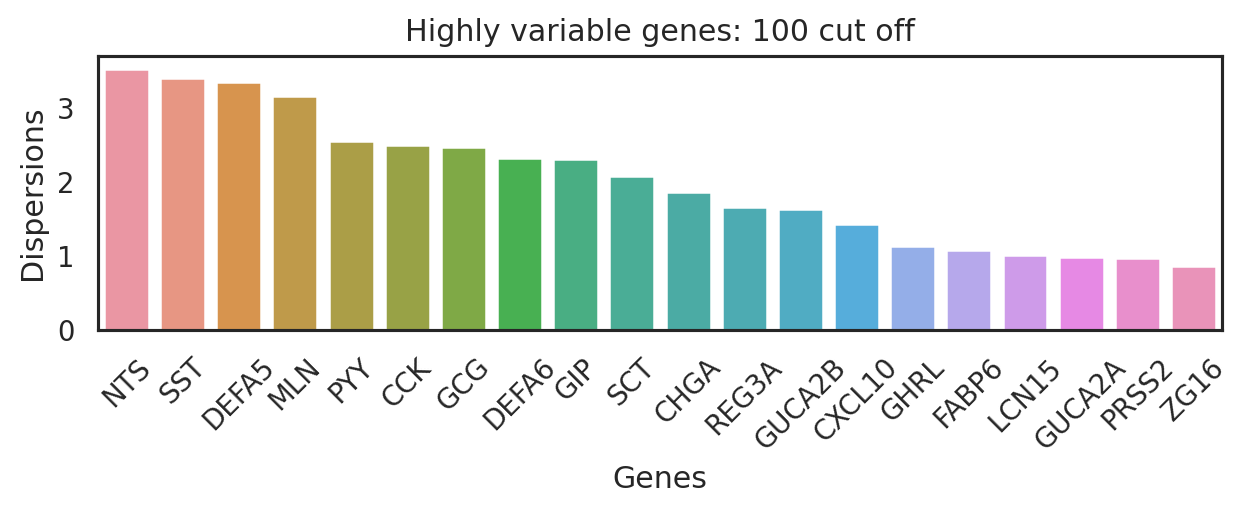

In [36]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_100, x=hv_100.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 100 cut off')

Text(0.5, 1.0, 'Highly variable genes: 200 cut off')

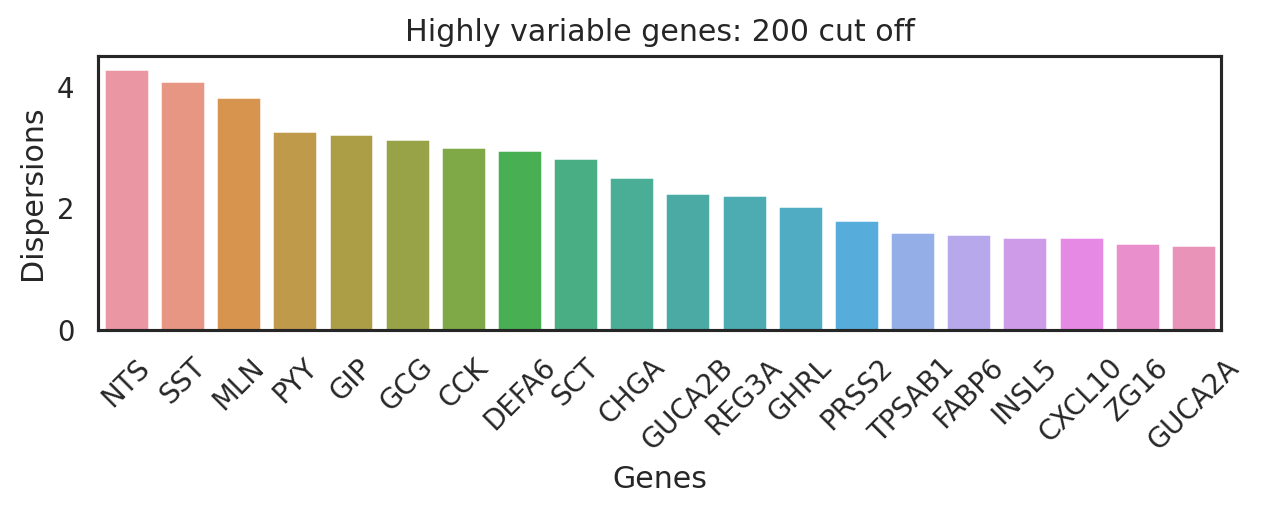

In [37]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_200, x=hv_200.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 200 cut off')

Text(0.5, 1.0, 'Highly variable genes: 300 cut off')

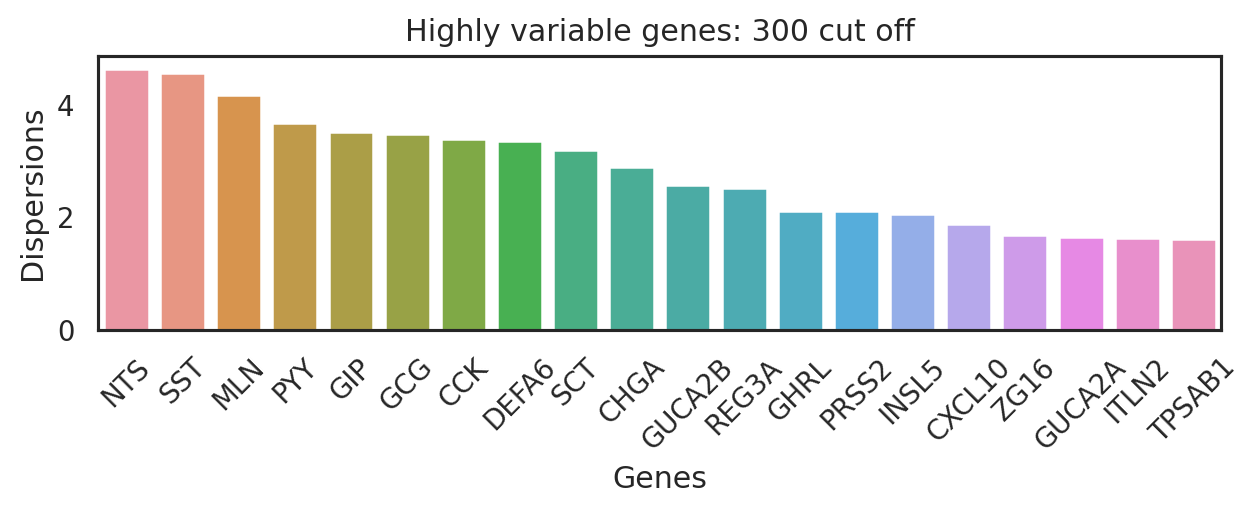

In [38]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_300, x=hv_300.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 300 cut off')

Text(0.5, 1.0, 'Highly variable genes: 400 cut off')

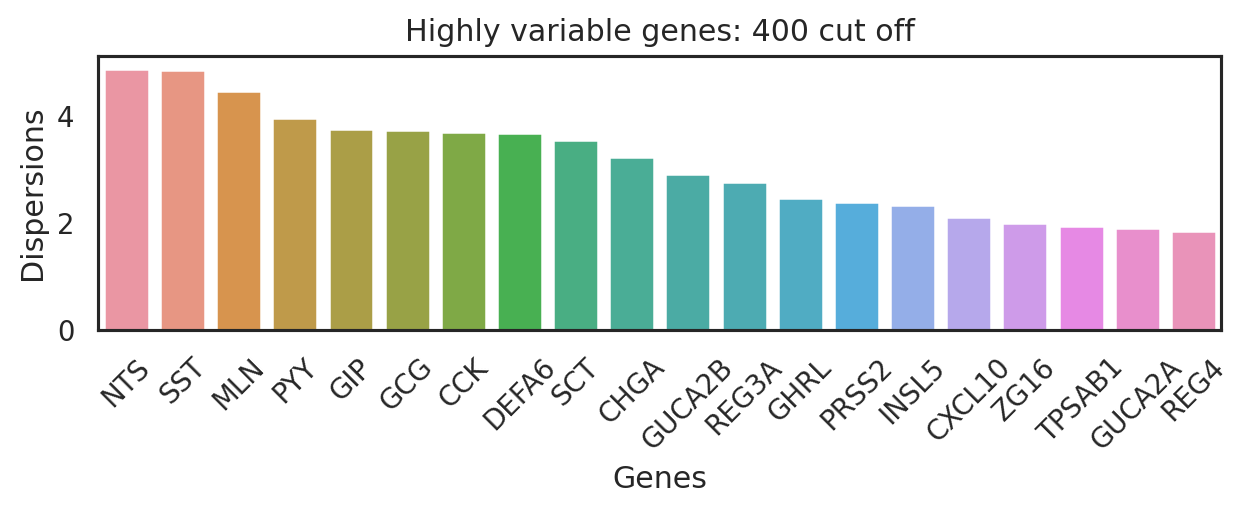

In [39]:
plt.figure(figsize=(8,2))
plt.xticks(rotation=45)
sns.barplot(data=hv_400, x=hv_400.index, y='dispersions')
plt.xlabel('Genes')
plt.ylabel('Dispersions')
plt.title('Highly variable genes: 400 cut off')

In [53]:
adata_500.obs['hash_cluster']

TGAATCGAGTTTCGAC-1-0    4
ACCCTCAAGTGTTCCA-1-0    4
CCACACTTCTCCTGTG-1-1    5
TGTCAGAGTACGTTCA-1-1    4
TTGTGGATCCGCGGAT-1-0    4
                       ..
AAGCCATGTCCGGCAT-1-1    4
ACTGTCCAGTATGATG-1-1    1
GTCTAGAGTGACTGTT-1-0    3
TTTCAGTCAGTTCTAG-1-2    5
TAGAGTCGTCGGTAAG-1-0    5
Name: hash_cluster, Length: 12590, dtype: int64

In [60]:
adata_500.obs.columns

Index(['hash_label', 'hash_cluster', 'n_genes', 'species', 'tissue', 'hashed',
       'sex', 'group', 'treatment', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'donor',
       'region', 'batch', 'S_score', 'G2M_score', 'phase', 'leiden', 'lineage',
       'type', 'organ', 'cds', 'donor_region', 'dpt_pseudotime',
       'log1p_n_genes_by_counts', 'log1p_total_counts', 'n_counts'],
      dtype='object')

In [63]:
adata_500.obs['batch'].unique()

['0', '1', '2']
Categories (3, object): ['0', '1', '2']

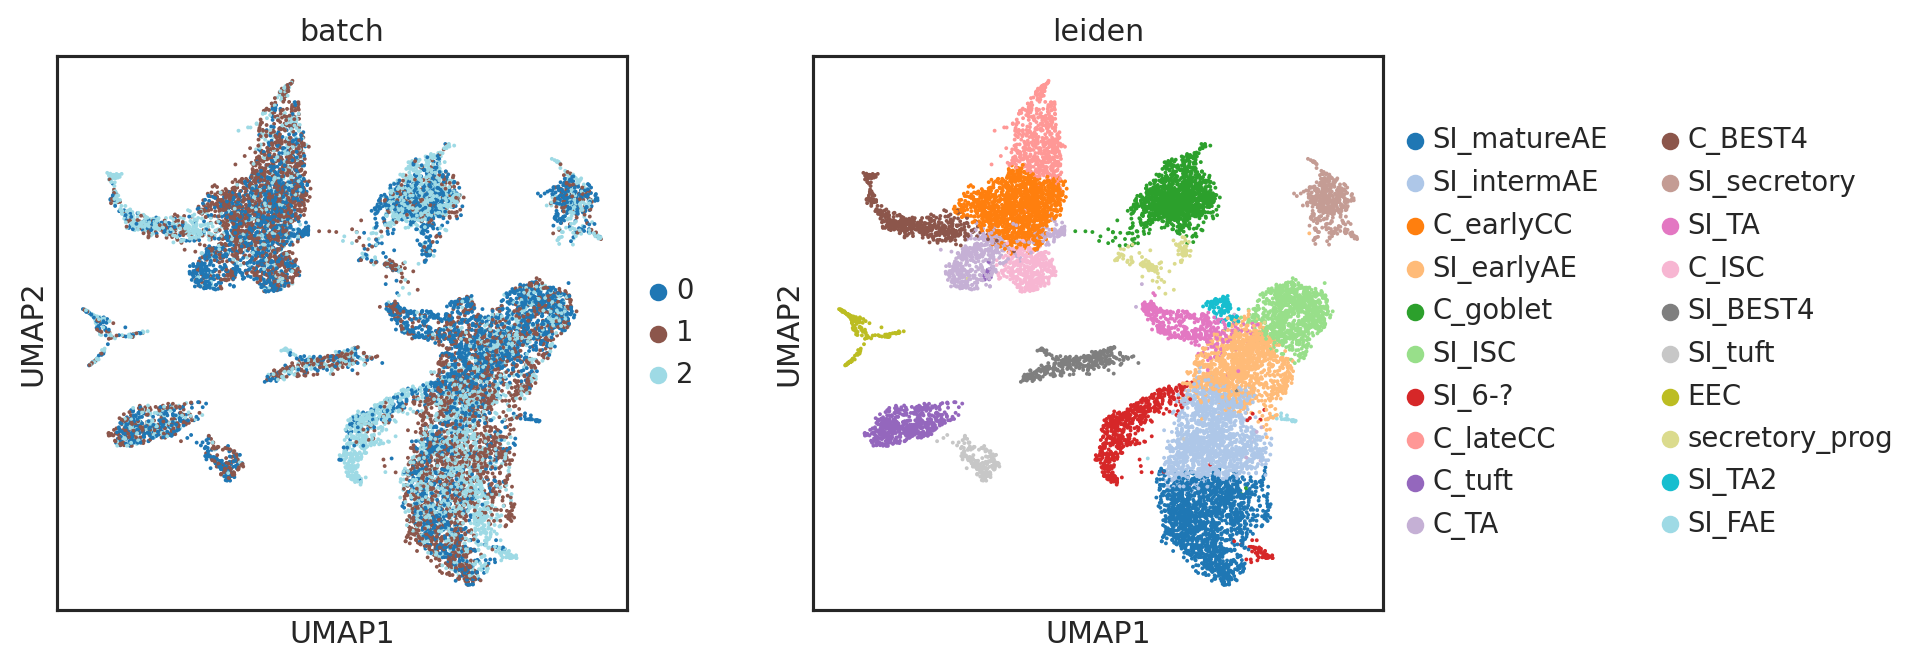

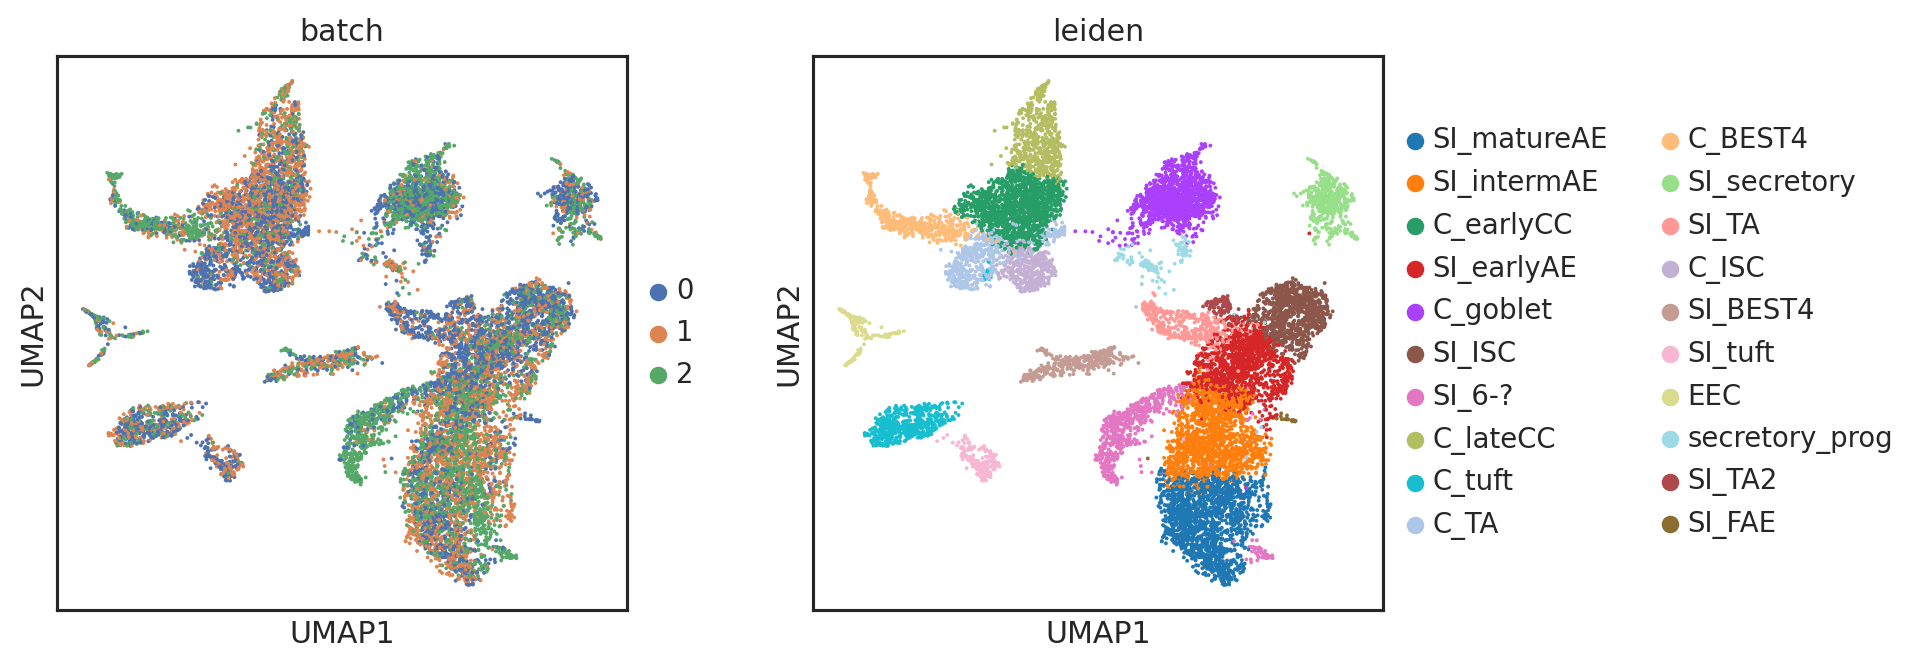

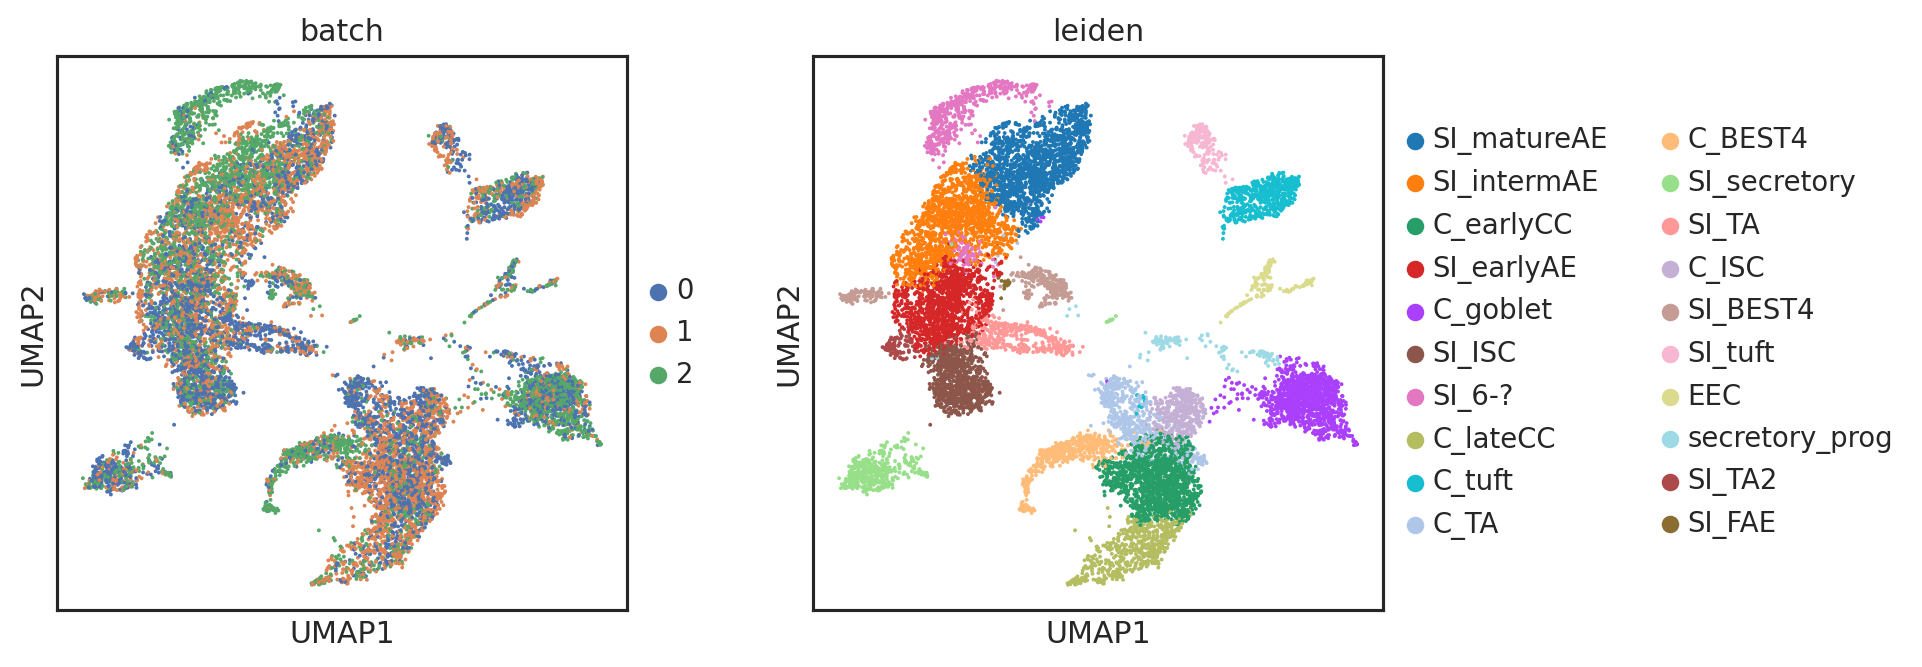

In [71]:
sc.pl.umap(adata, color=['batch', 'leiden'], cmap='tab10')
sc.pl.umap(adata_500, color=['batch', 'leiden'], cmap='tab10')
sc.pl.umap(adata_2000, color=['batch', 'leiden'], cmap='tab10')

# Let's evaluate batch integration after applying Harmony batch correction

In [66]:
import harmonypy as hm

In [67]:
hm_adata = adata.copy()

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [69]:
meta_data = pd.DataFrame(hm_adata.obs['batch'])
vars_use = ['batch']
data_mat = hm_adata.obsm['X_pca'][:,:5]
data_mat.shape
ho = hm.run_harmony(data_mat, meta_data, vars_use,max_iter_harmony=50)

res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

hm_adata.obsm['X_pca_harmony'] = res.T.values

neighborhood_k = np.sqrt(hm_adata.n_obs).astype(int) 

sc.pp.neighbors(hm_adata,n_neighbors=neighborhood_k,use_rep='X_pca_harmony',random_state=0)
sc.tl.umap(hm_adata,min_dist=0.25,random_state=0)
sc.tl.leiden(hm_adata,resolution=1,random_state=0)

2022-12-07 13:20:13,842 - harmonypy - INFO - Iteration 1 of 50
2022-12-07 13:20:15,865 - harmonypy - INFO - Iteration 2 of 50
2022-12-07 13:20:17,997 - harmonypy - INFO - Iteration 3 of 50
2022-12-07 13:20:20,264 - harmonypy - INFO - Iteration 4 of 50
2022-12-07 13:20:22,501 - harmonypy - INFO - Iteration 5 of 50
2022-12-07 13:20:23,657 - harmonypy - INFO - Iteration 6 of 50
2022-12-07 13:20:24,532 - harmonypy - INFO - Iteration 7 of 50
2022-12-07 13:20:25,221 - harmonypy - INFO - Iteration 8 of 50
2022-12-07 13:20:25,906 - harmonypy - INFO - Converged after 8 iterations
OMP: Info #274: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


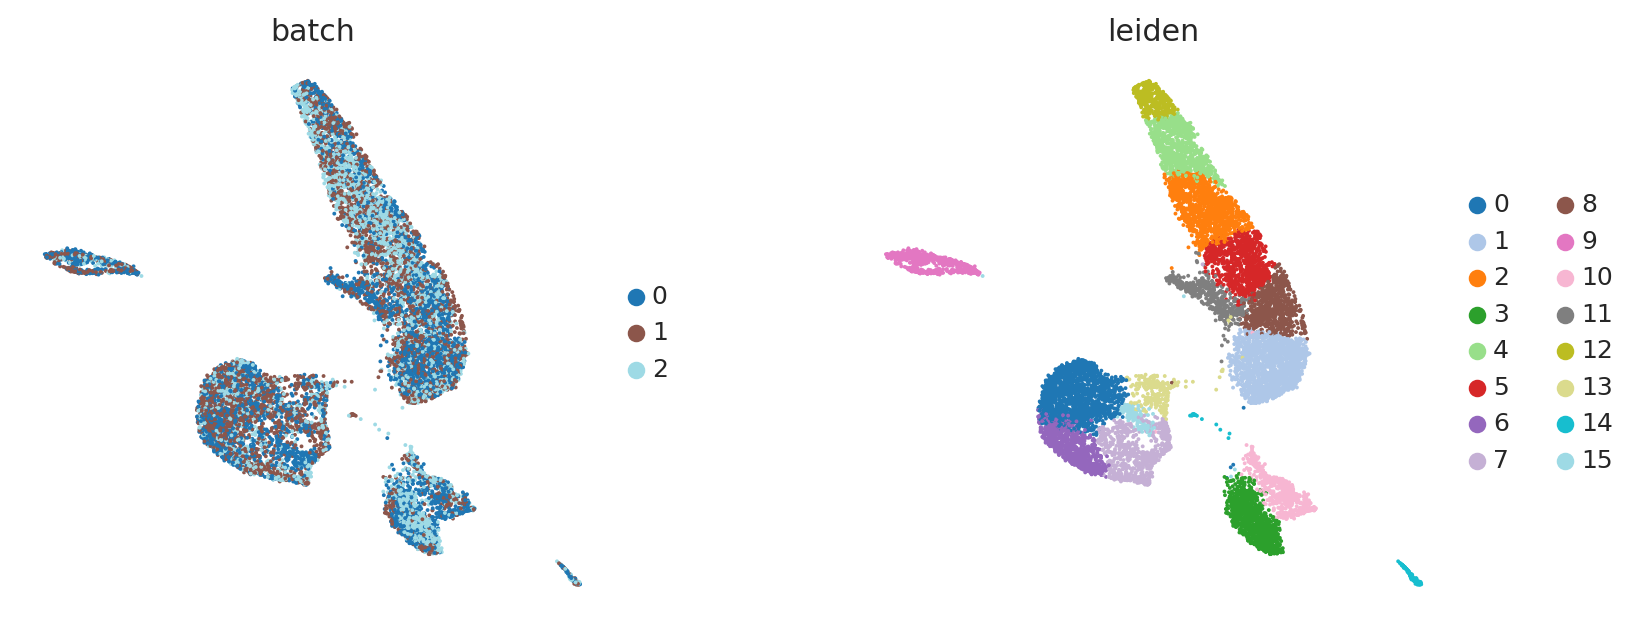

In [72]:
sc.pl.umap(hm_adata,color=['batch','leiden'],legend_fontoutline=True,legend_fontsize=10,palette='tab20',ncols=3,wspace=0.3,frameon=False)

In [74]:
import scib

In [92]:
adata.obs.columns

Index(['hash_label', 'hash_cluster', 'n_genes', 'species', 'tissue', 'hashed',
       'sex', 'group', 'treatment', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'donor',
       'region', 'batch', 'S_score', 'G2M_score', 'phase', 'leiden', 'lineage',
       'type', 'organ', 'cds', 'donor_region', 'dpt_pseudotime'],
      dtype='object')

In [86]:
hm_adata.obsm

AxisArrays with keys: X_pca, X_pca_harmony, X_umap

In [93]:
scib.metrics.pcr_comparison(adata, hm_adata, covariate='batch', embed=hm_adata.obsm['X_pca'])

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/scib/metrics/pcr.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if embed == "X_pca":


TypeError: unhashable type: 'numpy.ndarray'